<a href="https://colab.research.google.com/github/ShubhamKumar0209/Network_IDS/blob/main/IDS_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
]import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import io

print("Libraries Imported Successfully.")

Libraries Imported Successfully.


In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Unzip the file
# REPLACE 'IDS_Dataset.zip' with your actual zip file name on Drive
# If the file is inside a folder, use: '/content/drive/My Drive/FolderName/filename.zip'
zip_path = '/content/drive/MyDrive/IDS.zip'

output_folder = '/content/dataset_extracted'

print(f"Unzipping {zip_path}...")
# The ! command runs a shell command to unzip
!unzip -q "{zip_path}" -d "{output_folder}"
print("Unzip Complete.")

# 3. List files to find the CSV/Excel
print("\nFiles found in the extracted folder:")
for root, dirs, files in os.walk(output_folder):
    for file in files:
        print(os.path.join(root, file))

Mounted at /content/drive
Unzipping /content/drive/MyDrive/IDS.zip...
Unzip Complete.

Files found in the extracted folder:
/content/dataset_extracted/cicids2017_cleaned.csv


In [ ]:
# REPLACE this path with the one printed in the output above
file_path = '/content/dataset_extracted/cicids2017_cleaned.csv'

# Load the file
if file_path.endswith('.csv'):
    df = pd.read_csv(file_path)
elif file_path.endswith('.xlsx'):
    df = pd.read_excel(file_path)
else:
    # Fallback for weird formats, try csv
    df = pd.read_csv(file_path)

print("--- Dataset Preview ---")
print(df.head())
print("\n--- Column Names ---")
print(df.columns.tolist())

--- Dataset Preview ---
   Destination Port  Flow Duration  Total Fwd Packets  \
0                22        1266342                 41   
1                22        1319353                 41   
2                22            160                  1   
3                22        1303488                 41   
4             35396             77                  1   

   Total Length of Fwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                         2664                    456                      0   
1                         2664                    456                      0   
2                            0                      0                      0   
3                         2728                    456                      0   
4                            0                      0                      0   

   Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  \
0               64.975610             109.864573                    976   
1 

In [ ]:
# ==========================================
# USER CONFIGURATION
# ==========================================
TARGET_COLUMN = 'Attack Type'   # Your specific label column
BENIGN_LABEL = 'Normal Traffic' # Your specific safe label
# ==========================================

# 1. Cleaning: specific to Network datasets
# 'Flow Bytes/s' can sometimes be Infinity if Duration is 0. We must fix this.
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

print(f"Dataset Shape after cleaning: {df.shape}")

# 2. Split Features (X) and Target (y)
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]

# 3. Encode Categorical Features in X (if any remain)
# Most of your columns look numeric, but we double-check
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# 4. Split into Train and Test Sets (70% Train, 30% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Data Preprocessing Complete.")
print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

Dataset Shape after cleaning: (2520751, 53)
Data Preprocessing Complete.
Training Features Shape: (1764525, 52)
Testing Features Shape: (756226, 52)


In [ ]:
print("Training Random Forest Classifier... This may take a minute.")

# n_estimators=100 means 100 decision trees.
# n_jobs=-1 uses all available processors for speed.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

print("Training Complete!")

Training Random Forest Classifier... This may take a minute.
Training Complete!



--- Model Accuracy ---
Accuracy Score: 99.85%

--- Classification Report ---
                precision    recall  f1-score   support

          Bots       0.88      0.75      0.81       583
   Brute Force       1.00      1.00      1.00      2768
          DDoS       1.00      1.00      1.00     38521
           DoS       1.00      1.00      1.00     58277
Normal Traffic       1.00      1.00      1.00    628063
 Port Scanning       0.99      0.99      0.99     27360
   Web Attacks       0.99      0.97      0.98       654

      accuracy                           1.00    756226
     macro avg       0.98      0.96      0.97    756226
  weighted avg       1.00      1.00      1.00    756226



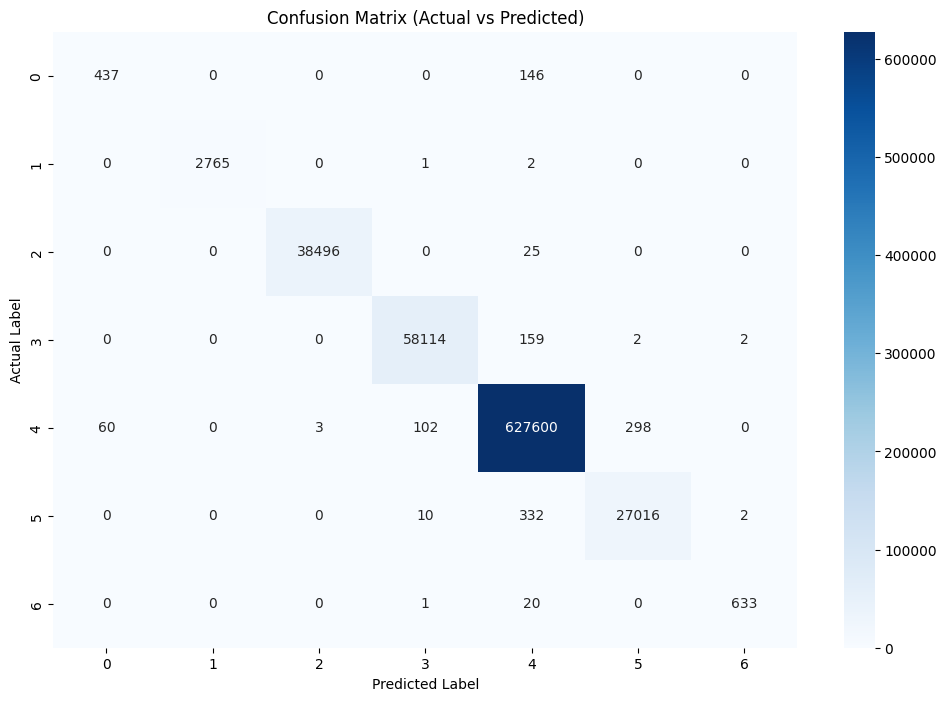

In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Print Metrics
print("\n--- Model Accuracy ---")
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {acc*100:.2f}%")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
plt.figure(figsize=(12,8)) # Made larger for readability
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Actual vs Predicted)")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


--- Top 10 Features Driving Detection ---
1. Bwd Packet Length Std (0.0913)
2. Packet Length Variance (0.0847)
3. Packet Length Std (0.0581)
4. Average Packet Size (0.0512)
5. Max Packet Length (0.0464)
6. Subflow Fwd Bytes (0.0452)
7. Total Length of Fwd Packets (0.0409)
8. Bwd Packet Length Mean (0.0394)
9. Packet Length Mean (0.0377)
10. Fwd Packet Length Max (0.0316)


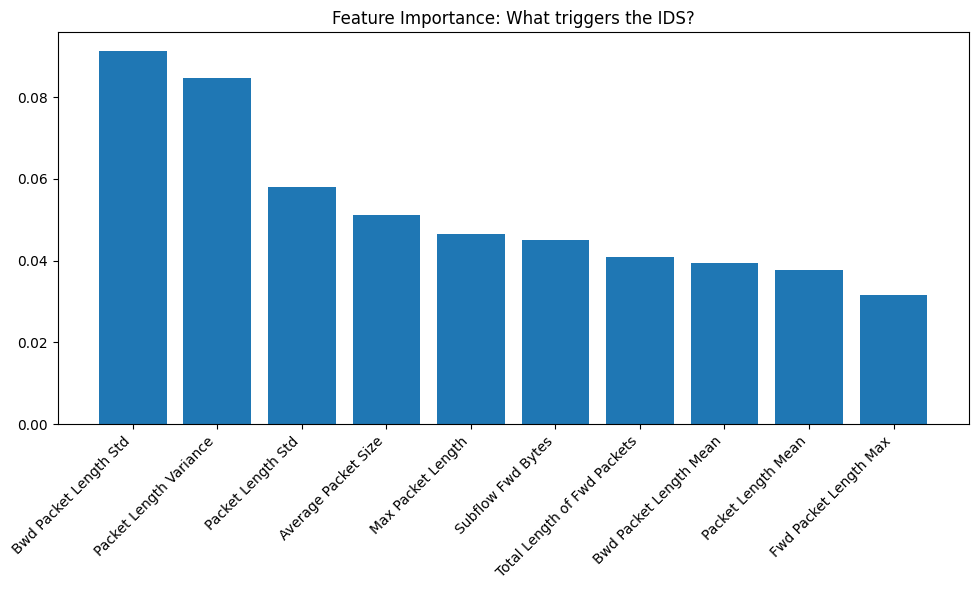

In [ ]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  # Show top 10 features

print("\n--- Top 10 Features Driving Detection ---")
for f in range(top_n):
    print(f"{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")

plt.figure(figsize=(10,6))
plt.title("Feature Importance: What triggers the IDS?")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X.columns[indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Automated Incident Response Simulation ---")

# Pick a random sample from the test set
random_idx = np.random.randint(0, len(X_test))
sample_traffic = X_test.iloc[random_idx:random_idx+1]
true_label = y_test.iloc[random_idx]

# Model Prediction
prediction = rf_model.predict(sample_traffic)[0]
confidence = np.max(rf_model.predict_proba(sample_traffic))

print(f"True Label:       {true_label}")
print(f"Model Prediction: {prediction}")
print(f"Confidence Level: {confidence*100:.2f}%")

print("\n--- AUTOMATED RESPONSE LOG ---")

# LOGIC:
# If NOT Normal AND High Confidence -> BLOCK
# If NOT Normal AND Low Confidence  -> ALERT
# If Normal -> ALLOW

if prediction != BENIGN_LABEL:
    if confidence > 0.90:
        print(f"⛔ [CRITICAL] Malicious traffic detected ({prediction}).")
        print("   ACTION: Firewall Rule Applied. Source IP Blocked immediately.")
    else:
        print(f"⚠️ [WARNING] Suspicious traffic detected ({prediction}).")
        print("   ACTION: Ticket #1024 created for Security Analyst review.")
else:
    print("✅ [INFO] Normal Traffic detected.")
    print("   ACTION: Allowed.")


--- Automated Incident Response Simulation ---
True Label:       Normal Traffic
Model Prediction: Normal Traffic
Confidence Level: 100.00%

--- AUTOMATED RESPONSE LOG ---
✅ [INFO] Normal Traffic detected.
   ACTION: Allowed.


In [ ]:
import time
import random

print("\n--- 🛡️ STARTING LIVE TRAFFIC MONITORING SYSTEM 🛡️ ---")
print("Listening for incoming packets...\n")

# Simulate processing 15 random packets
for i in range(1, 16):
    # Get random sample
    random_idx = np.random.randint(0, len(X_test))
    sample = X_test.iloc[random_idx:random_idx+1]
    true_lbl = y_test.iloc[random_idx]

    # Predict
    pred = rf_model.predict(sample)[0]
    conf = np.max(rf_model.predict_proba(sample))

    # Get timestamp
    timestamp = time.strftime("%H:%M:%S")

    # OUTPUT FORMATTING
    if pred == BENIGN_LABEL:
        # Green check for normal
        print(f"[{timestamp}] ✅ ALLOWED: Packet #{random_idx} | Protocol: TCP | Status: Normal")
    else:
        # Logic for Attack
        if conf > 0.90:
            print(f"[{timestamp}] ⛔ BLOCKED: Packet #{random_idx} | Type: {pred} | Conf: {conf*100:.1f}% | Action: Drop & Blacklist IP")
        else:
            print(f"[{timestamp}] ⚠️ ALERT:   Packet #{random_idx} | Type: {pred} | Conf: {conf*100:.1f}% | Action: Notify Analyst")

    # Sleep to simulate real-time traffic arrival (0.5 to 1.5 seconds)
    time.sleep(random.uniform(0.2, 0.8))

print("\n--- MONITORING STOPPED ---")


--- 🛡️ STARTING LIVE TRAFFIC MONITORING SYSTEM 🛡️ ---
Listening for incoming packets...

[16:12:32] ✅ ALLOWED: Packet #59812 | Protocol: TCP | Status: Normal
[16:12:33] ✅ ALLOWED: Packet #169498 | Protocol: TCP | Status: Normal
[16:12:33] ✅ ALLOWED: Packet #453869 | Protocol: TCP | Status: Normal
[16:12:33] ✅ ALLOWED: Packet #613529 | Protocol: TCP | Status: Normal
[16:12:34] ⛔ BLOCKED: Packet #592640 | Type: Port Scanning | Conf: 100.0% | Action: Drop & Blacklist IP
[16:12:35] ✅ ALLOWED: Packet #432342 | Protocol: TCP | Status: Normal
[16:12:35] ⛔ BLOCKED: Packet #625394 | Type: DoS | Conf: 100.0% | Action: Drop & Blacklist IP
[16:12:36] ⛔ BLOCKED: Packet #495937 | Type: DoS | Conf: 100.0% | Action: Drop & Blacklist IP
[16:12:36] ✅ ALLOWED: Packet #238686 | Protocol: TCP | Status: Normal
[16:12:37] ⛔ BLOCKED: Packet #16438 | Type: DoS | Conf: 100.0% | Action: Drop & Blacklist IP
[16:12:37] ✅ ALLOWED: Packet #586602 | Protocol: TCP | Status: Normal
[16:12:38] ✅ ALLOWED: Packet #107511

In [ ]:
import joblib

# Save the model to a file
model_filename = 'ids_random_forest_model.pkl'
joblib.dump(rf_model, model_filename)

print(f"Model saved as '{model_filename}'")

# Download it to your computer
from google.colab import files
files.download(model_filename)

Model saved as 'ids_random_forest_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import files

# Take 200 random rows from your test set to act as "live traffic"
# We save the label too so the script knows if it was actually an attack
simulation_data = X_test.sample(n=200, random_state=42)
simulation_data['Actual_Label'] = y_test.loc[simulation_data.index]

# Save to CSV
simulation_data.to_csv('simulated_traffic.csv', index=False)
print("File created successfully.")

# Download
files.download('simulated_traffic.csv')

File created successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>